# GROVER lösen SODUKU Problem

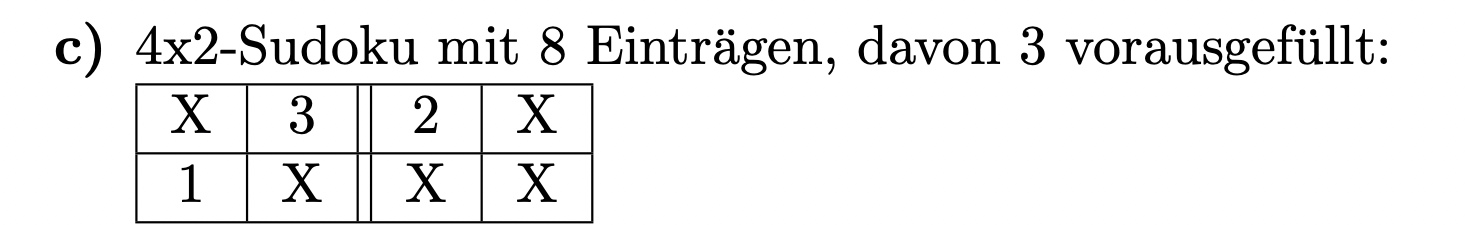

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister,\
    ClassicalRegister,transpile, Aer, IBMQ,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def reflection(qc,x):
    '''Performs reflection around state |0>: adds a negative phase only to state |0>'''
    qc.x(x) #apply X to whole register
    qc.h(x[-1]) #apply hadamard to last qubit
    qc.mcx(x[:-1],x[-1]) #apply multi control x gate
    qc.h(x[-1])
    qc.x(x)
def diffuser(qc,x):
    '''Transforms superposition state |s> -> |0>, reflects about |0>
    and transforms back to |s> again.'''
    qc.h(x)
    reflection(qc,x)
    qc.h(x)

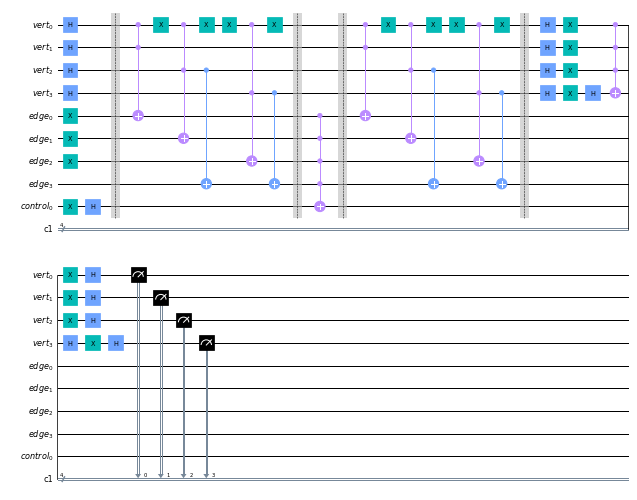

In [9]:
vert = QuantumRegister(4, name ='vert')
edg = QuantumRegister(4, name ='edge')
contr = QuantumRegister(1, name ='control')
cr = ClassicalRegister(4)
qc = QuantumCircuit(vert, edg, contr, cr)

#the rest are unknown: apply H
qc.h(vert)
#set control qubit in state |->
qc.x(contr)
qc.h(contr)

qc.x(edg[:-1])
qc.barrier()
#apply U_f

#encode edges
#1-2
qc.ccx(vert[0], vert[1], edg[0])
#3-4
qc.x(vert[0])
qc.ccx(vert[0], vert[2], edg[1])
qc.x(vert[0])
#3-5
qc.x(vert[0])
qc.ccx(vert[0], vert[3], edg[2])
qc.x(vert[0])
#3-4
qc.cx(vert[2], edg[3])
qc.cx(vert[3], edg[3])
#add negative amplitude to the state with all ones (all edges connecting nodes with different colours)
qc.barrier()
qc.mcx(edg,contr)
qc.barrier()
#reverse edge encoding
#1-2
qc.ccx(vert[0], vert[1], edg[0])
#3-4
qc.x(vert[0])
qc.ccx(vert[0], vert[2], edg[1])
qc.x(vert[0])
#3-5
qc.x(vert[0])
qc.ccx(vert[0], vert[3], edg[2])
qc.x(vert[0])
#3-4
qc.cx(vert[2], edg[3])
qc.cx(vert[3], edg[3])

qc.barrier()
#diffuser
diffuser(qc,vert[:])

qc.measure(vert[:],cr)
qc.draw('mpl', scale=0.5)

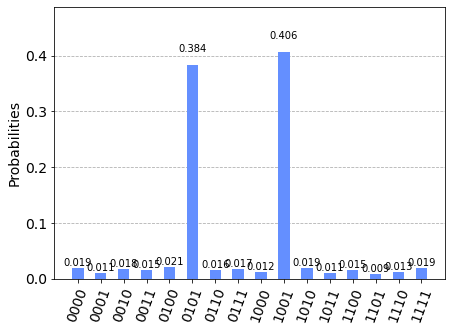

In [10]:
#run on simulator
backend = Aer.get_backend('qasm_simulator') 
result = execute(qc, backend).result()

plot_histogram(result.get_counts())

In [11]:
result = result.get_counts(qc).most_frequent()

In [12]:
result

'1001'

In [13]:
pass_ = Unroller(['u3', 'cx', 'p'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)
ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

OrderedDict([('u3', 160), ('cx', 90), ('p', 15), ('barrier', 4), ('measure', 4)])
Cost: 1060


In [14]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 178
Gate counts: OrderedDict([('u3', 175), ('cx', 90), ('barrier', 4), ('measure', 4)])
Optimization Level 1
Depth: 154
Gate counts: OrderedDict([('u3', 122), ('cx', 90), ('barrier', 4), ('measure', 4)])
Optimization Level 2
Depth: 154
Gate counts: OrderedDict([('u3', 122), ('cx', 90), ('barrier', 4), ('measure', 4)])
Optimization Level 3
Depth: 154
Gate counts: OrderedDict([('u3', 122), ('cx', 90), ('barrier', 4), ('measure', 4)])


In [15]:
pass_ = Unroller(['u3', 'cx', 'p'])
pm = PassManager(pass_)
new_circuit = pm.run(trans_qc)
ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))

OrderedDict([('u3', 122), ('cx', 90), ('barrier', 4), ('measure', 4)])
Cost: 1022
